# Load and prepare the data

## Import librairies

In [1]:
import requests
import tweepy
import webbrowser
import os
from datetime import date, datetime

import pandas as pd
import numpy as np

import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
import string
import unidecode

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from IPython.display import display, Image

## Import keys

In [3]:
from raw_data import keys
twitter_api_key = keys.twitter_api_key()
twitter_api_secret_key = keys.twitter_api_key_secret()
twitter_bearer_token = keys.twitter_bearer_token

## Connect my developer project to my twitter profile

In [4]:
callback_uri = "oob" # url
auth = tweepy.OAuthHandler(twitter_api_key, twitter_api_secret_key, callback_uri)
redirect_url = auth.get_authorization_url()
print(redirect_url)

https://api.twitter.com/oauth/authorize?oauth_token=_nGgjwAAAAABUe3MAAABfVyfyrk


In [5]:
m=

SyntaxError: invalid syntax (1928120398.py, line 1)

In [5]:
user_pin_value = '1399869'
auth.get_access_token(user_pin_value)
api = tweepy.API(auth)

## Load new content

### Function to extract the tweets of politicals that I follow

In [6]:
candidates_pseudo = """yjadot xavierbertrand vpecresse regis_ollivier philippejuvin n_arthaud montebourg luclaf larrouturou jfpoisson78 jeanlassalle gilleslazzarini gerardfiloche f_philippot dupontaignan antoine27955080 ZemmourEric Waechter2022 Vukuzman UPR_Asselineau PhilippePoutou MichelBarnier MartinRocca2022 MarCharlott MLP_officiel MAZUEL_Pace JaclineMouraud JLMelenchon HeleneThouy GildasVieira FabriceGrimal Fabien_Roussel EmmanuelMacron EPhilippe_LH ECiotti DenisPayre ClaraEgger1 Cau_Marie_ Anne_Hidalgo AnasseKazib AlexLanglois_ AguebPorterie"""
# We do not "clean" candidates pseudo to keep their original format which is important here
candidates_pseudo_list = word_tokenize(candidates_pseudo)

In [7]:
def extract_tweets_from_politics(number_of_tweet_per_politic, candidates_pseudo_list):
    """This function return a DataFrame of the last tweets of politics that I follow on Twitter"""
    
    # Start by working on my own account
    me = api.get_user(screen_name="alecoursonnois")
    # Generate a list of my all of my friends (considering that I have under 50 friends on twitter)
    my_friends = me.friends(count=50)
    
    # Retrieve my personal friends which I don't want to analyze their tweets
    politics = candidates_pseudo_list
    
    # Create a set to stock the DataFrame columns names
    columns = set()
    # Create a list to save each tweet and its datas
    tweets_data = []
    # Create to save politics screen_names
    politics_screen_name = []
    
    # Iterate on my_friends
    for friend in my_friends:
        friend_name = friend.screen_name
        
        # Don't act if this friend is out of the project
        if friend_name in politics:
            # Generate politics timeline list of the last tweets (the number must be indicated as a function's argument)
            timeline_list = api.get_user(screen_name=friend_name).timeline(count=number_of_tweet_per_politic, tweet_mode="extended")
            
            # Iterate on each tweet
            for status in timeline_list:
                # Generate a dictionary of status attributes
                status_dict = dict(vars(status))
                
                # From this dictionary, get the keys and stock it in a variable
                keys = vars(status).keys()
                
                # Create a dictionary stocking each status of the politic we are working on
                # This dictionary will be added to the "tweets_data" list and finaly convert into a DataFrame
                single_tweet_data = {}
    
                # Iterate on each status key (future column name)
                for k in keys:
                    # Add the status data to its right key into the dictionary of each status
                    single_tweet_data[k] = status_dict[k]
                    # Add the key as a column name in the set
                    columns.add(k)
                
                # Append the full single_tweet_data dictionary with the right key to the tweets_data list
                tweets_data.append(single_tweet_data)

    # Give a name to the columns respecting the order
    headers_cols = list(columns)

    # Allow the DataFrame to display full tweets when printed
    pd.set_option("display.max_rows", None, "display.max_columns", None)
    
    # Convert the tweets_data list into a DataFrame
    df = pd.DataFrame(tweets_data)
    
    # Only keep columns that provides information
    columns_to_keep = ['id', '_json', 'source', 'source_url', 'retweet_count']
    df = df[columns_to_keep]
    
    # Generate new features from extracted data
    df["user"] = df["_json"].apply(lambda x : x["user"]["screen_name"])
    df["created_date"] = pd.to_datetime(df["_json"].apply(lambda x : x["created_at"])).dt.strftime("%Y-%m-%d")
    df["created_hour"] = pd.to_datetime(df["_json"].apply(lambda x : x["created_at"])).dt.strftime("%H:%M:%S")
    df["text"] = df["_json"].apply(lambda x : x["full_text"])
    df["hashtags"] = df["_json"].apply(lambda x : [hasthstags["text"] for hasthstags in x["entities"]["hashtags"]])
    
    # All url needed to display tweets with streamlit
    all_url = []
    # Iterate over "_json" to concatenate urls
    for content in df["_json"]:
        start = "https://twitter.com/"
        user = content["user"]["screen_name"]
        complement = "/status/"
        id_str = content["id_str"]
        # Concatenate
        full_url = start + user + complement + id_str
        # Append to the full list
        all_url.append(full_url)
    # Create the column
    df["url"] = all_url
    
    # Reorder columns
    right_order = ["user", "id", "source", "text", "created_date", "created_hour", "hashtags", "retweet_count", "url"]
    df = df[right_order]
    
    return df

### Apply the function

In [8]:
# Load new tweets
last_tweets_df = extract_tweets_from_politics(number_of_tweet_per_politic=250, candidates_pseudo_list=candidates_pseudo_list)
last_tweets_df.shape

(8137, 9)

### Add features

#### Generate new_features

In [9]:
new_features = [{"user":'EPhilippe_LH', "name": "Edouard Philippe","political_party":"Horizons", "political_orientation":"droite"},
                 {"user":'ZemmourEric', "name": "Eric Zemmour", "political_party":"Aucun", "political_orientation":"extrême_droite"},
                 {"user":'EmmanuelMacron', "name": "Emmanuel Macron", "political_party":"La République En Marche", "political_orientation":"droite"},
                 {"user":'Waechter2022', "name": "Antoine Waechter", "political_party":"Mouvement Ecologiste Independant", "political_orientation":"ecologie"},
                 {"user":'Fabien_Roussel', "name": "Fabien Roussel", "political_party":"Parti Communiste Français", "political_orientation":"extrême_gauche"},
                 {"user":'PhilippePoutou', "name": "Philippe Poutou", "political_party":"Nouveau Parti Anticapitaliste", "political_orientation":"extrême_gauche"},
                 {"user":'jfpoisson78', "name": "Jean-Frédéric Poisson", "political_party":"La Voie du Peuple", "political_orientation":"extrême_droite"},
                 {"user":'f_philippot', "name": "Florian Philippot", "political_party":"Les Patriotes", "political_orientation":"extrême_droite"},
                 {"user":'vpecresse', "name": "Valérie Pécresse", "political_party":"Soyons Libres", "political_orientation":"droite"},
                 {"user":'DenisPayre', "name": "Denis Payre", "political_party":"Les Républicains", "political_orientation":"droite"},
                 {"user":'montebourg', "name": "Arnaud Montebourg", "political_party":"L'Engagement", "political_orientation":"gauche"},
                 {"user":'JLMelenchon', "name": "Jean-Luc Mélenchon", "political_party":"La France Insoumise", "political_orientation":"extrême_gauche"},
                 {"user":'MLP_officiel', "name": "Marine Le Pen", "political_party":"Front National", "political_orientation":"extrême_droite"},
                 {"user":'jeanlassalle', "name": "Jean Lassale", "political_party":"Résistons", "political_orientation":"divers"},
                 {"user":'larrouturou', "name": "Pierre Larrouturou", "political_party":"Nouvelle Donne", "political_orientation":"gauche"},
                 {"user":'philippejuvin', "name": "Philippe Juvin", "political_party":"Les Républicains", "political_orientation":"droite"},
                 {"user":'yjadot', "name": "Yannick Jadot", "political_party":"Europe Ecologie-Les Verts", "political_orientation":"ecologie"},
                 {"user":'Anne_Hidalgo', "name": "Anne Hidalgo", "political_party":"Parti Socialiste", "political_orientation":"gauche"},
                 {"user":'gerardfiloche', "name": "Gerard Filoche", "political_party":"La Gauche Démocratique et Sociale", "political_orientation":"extrême_gauche"},
                 {"user":'dupontaignan', "name": "Nicolas Dupont-Aignan", "political_party":"Debout la France", "political_orientation":"extrême_droite"},
                 {"user":'ECiotti', "name": "Eric Ciotti", "political_party":"Les Républicain", "political_orientation":"droite"},
                 {"user":'xavierbertrand', "name": "Xavier Bertrand", "political_party":"La Manufacture", "political_orientation":"droite"},
                 {"user":'MichelBarnier', "name": "Michel Barnier", "political_party":"Les Républicains", "political_orientation":"droite"},
                 {"user":'UPR_Asselineau', "name": "François Asselineau", "political_party":"Union Populaire Républicaine", "political_orientation":"divers"},
                 {"user":'n_arthaud', "name": "Nathalie Arthaud", "political_party":"Lutte Ouvrière", "political_orientation":"extrême_gauche"},
                 {"user":'MartinRocca2022', "name": "Martin Rocca", "political_party":"Constituante 2022", "political_orientation":"divers"},
                 {"user":'gilleslazzarini', "name": "Gilles Lazzarini", "political_party":"Parti Politique pour la Paix et la Protection de la Planète", "political_orientation":"divers"},
                 {"user":'AlexLanglois_', "name": "Alex Langlois", "political_party":"Refondation 2022", "political_orientation":"divers"},
                 {"user":'luclaf', "name": "Luc Laforets", "political_party":"Une Perspective - la 6e République", "political_orientation":"divers"},
                 {"user":'Vukuzman', "name": "Georges Kuzmanovic", "political_party":"République Souveraine", "political_orientation":"divers"},
                 {"user":'FabriceGrimal', "name": "Fabrice Grimal", "political_party":"La Concorde Citoyenne 2022", "political_orientation":"divers"},
                 {"user":'ClaraEgger1', "name": "Clara Egger", "political_party":"Espoir RIC 2022", "political_orientation":"divers"},
                 {"user":'Cau_Marie_', "name": "Marie Cau", "political_party":"Sans Etiquette", "political_orientation":"divers"},
                 {"user":'antoine27955080', "name": "Antoine Martinez", "political_party":"Volontaires pour la France", "political_orientation":"extrême_droite"},
                 {"user":'regis_ollivier', "name": "Régis Ollivier", "political_party":"Indépendant", "political_orientation":"droite"},
                 {"user":'JaclineMouraud', "name": "Jacline Mouraud", "political_party":"Sans Etiquette", "political_orientation":"droite"},
                 {"user":'HeleneThouy', "name": "Hélène Thouy", "political_party":"Parti Animaliste", "political_orientation":"ecologie"},
                 {"user":'MAZUEL_Pace', "name": "Philippe Mazuel", "political_party":"Pace", "political_orientation":"gauche"},
                 {"user":'MarCharlott', "name": "Charlotte Marchandise", "political_party":"Sans Etiquette", "political_orientation":"gauche"},
                 {"user":'AguebPorterie', "name": "Anna Agueb-Porterie", "political_party":"Aucun", "political_orientation":"gauche"},
                 {"user":'AnasseKazib', "name": "Anasse Kazib", "political_party":"Courant Communiste Révolutionnaire-Révolution Permanente", "political_orientation":"extrême_gauche"},
                 {"user":'Stauthui', "name": "Stéphane Tauthui", "political_party":"Tous France", "political_orientation":"droite"},
                 {"user":'GildasVieira', "name": "Gildas Vieira", "political_party":"La France autrement", "political_orientation":"divers"},]

In [10]:
new_features_df = pd.DataFrame(new_features)

#### Merge it to last_tweets_df

In [11]:
# because M Rocca changed his accounts name we must change our informations
last_tweets_df["user"] = last_tweets_df["user"].str.replace("MartinRocca12", "MartinRocca2022")

In [12]:
last_tweets_df = pd.merge(left=last_tweets_df, right=new_features_df, on='user', how='left')

### Check the number of tweets per politics

In [ ]:
# last_tweets_df["user"].value_counts()

### Add it to the main global DataFrame

#### Load the global_df 
- and drop the last index column automatically named "Unamed: 0" when saving df to csv file

In [13]:
global_df = pd.read_csv("global_df.csv").drop(columns="Unnamed: 0")

#### Add new content

In [14]:
actual_number_of_tweets = global_df.shape[0]

# Append last tweets loaded to our archives
global_df = global_df.append(last_tweets_df, ignore_index=True)

# Sort the df by retweet_count to be sure to only keep the last update of retweet_count
global_df = global_df.sort_values('retweet_count', ascending=False).drop_duplicates(["user", "id", "source", "text", "created_date", "created_hour", "name", "political_party","political_orientation"])

print(f"We just added {global_df.shape[0]-actual_number_of_tweets} tweets to our global_df")

We just added 652 tweets to our global_df


#### Save the new global_df

In [15]:
global_df.shape

(9394, 12)

In [16]:
global_df["user"] = global_df["user"].str.replace("MartinRocca12", "MartinRocca2022")

In [17]:
global_df.to_csv("global_df.csv")

## Clean tweets

### Make a new df from the global one
- This way we will be allowed to drop duplicates next time we will load the global_df from the csv file

In [18]:
df_ready_for_nlp = global_df.copy()

### Retrieve recurrent regex

#### Retweets

In [19]:
def retrieve_rt_retweets(df):
    new_texts = []
    
    for text in df["text"]:
        if text[:3] == 'RT ' or text[:3] == 'rt ':
            new_texts.append(text[3:])
        else:
            new_texts.append(text)
    
    df["text"] = new_texts
    
    return df

In [20]:
df_ready_for_nlp = retrieve_rt_retweets(df_ready_for_nlp)

#### Links

In [21]:
def retrieve_links(df):
    pattern = re.compile("https://*")
    new_text = []

    for text in df["text"]:
        if re.search(pattern, text) is None:
            new_text.append(text)
        else:
            match_position = re.search(pattern, text).span()[0]
            new_text.append(text[:(match_position-1)])

    df["text"] = new_text
    
    return df

In [22]:
df_ready_for_nlp = retrieve_links(df_ready_for_nlp)


### Retrieve punctuation, lower text, tokenize, stopwords

#### Define a text_cleaner function

In [23]:
def text_cleaner(text):
    # Remove Punctuation
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ') 
    
    # Lower Case
    lowercased = text.lower() 
    
    # Remove accents
    unaccented_string = unidecode.unidecode(lowercased) 
    
    # Tokenize
    tokenized = word_tokenize(unaccented_string) 
    
    # Remove numbers
    words_only = [word for word in tokenized if word.isalpha()] 
    
    # Make stopword list
    stop_words = set(stopwords.words('french')) 
    
    # Remove Stop Words
    without_stopwords = [word for word in words_only if not word in stop_words]
    
    return " ".join(without_stopwords)

#### Apply the text_cleaner function

In [24]:
df_ready_for_nlp['text'] = df_ready_for_nlp['text'].apply(text_cleaner)

## Analyze tweets

### Find lexical themes and store their vocabulary in lists

In [25]:
ecology_lexicon = """velotafeurs velotaf vélo SolutionVelo Climate Amazonie éolien Coal coal lecologie2022 ISFClimatique ecologistes vivant verte vert végétale trophique transitionénergétique transition surpopulation recyclage productivisme préservation pollution phytogéographie permaculture organisme oikos océanographie Nucléaire nucléaire naturel nature microbiologie mésologie MEI Mei intertidale impact Hulot guilde Greenpeace GIEC GiEC génération évolution éthologie ethnographie environnementale environnement énergie élevage écosystème éconavigation écologue écologiste écologisme écologique écologie écoguerrier écocitoyenneté durable diversité décroissance cours Cop26 cop26 COP26 climat Climat bobo biotope biotique biosphère bionomie biomasse biologique biologie biogéographie biodiversité biocénose altermondialiste agroalimentaire Agriculture agriculture agricole AccorddeParis AccordDeParis abiotique"""
ecology_lexicon_list = word_tokenize(ecology_lexicon)
ecology_lexicon_clean_list = word_tokenize(text_cleaner(ecology_lexicon))

In [26]:
extrem_lexicon = """rage xénophobie violent violence vif vieillesse vertigineux ultime toundra tétracorde terrible terreur terminal tension température susceptibilité survie surexcitation surabondant suprême superlatif soutenir sommet skinhead simplicité Sibérie sévérité sécheresse risqué rigueur relooking redoutable rareté raffinement radical raciste racisme puissance prudence prostration profond précipitation préciosité plafond piètre pénurie passionné particulier paroxysmique paroxysme paresseux pâleur outrée outrancier opposition opposé onction obligeance nudité nervosité néonazi nébulosité musoir mouvance mortel monstrueux mollesse miséricorde minimal minceur metal méprisable méfiance maximum maximal maigreur lourdeur Lolita limite lenteur laideur Laconie Kolyma intensif intense insupportable insensibilité inouï injuste inique infini individualisme immodéré immense hypersexualisation hypersensibilité horrible horreur Heyman héroïque haut hasardeux groupuscule gravité glacial furieux funeste fragilité fou fondamental folle finesse férocité fatigue fasciste faiblesse facho extrêmophile extrémité extrémiste extrémisme extrémiser extrémisation extrêmement extrême extraordinaire extase exquis exorbitant excessif excès exceptionnel exaspéré exagérer épuisement épouvantable éperdu énergique électorat effroyable effréné effrayant ECW dureté drastique draconien disproportionné disproportion discrétion détresse désordonné désolation désespérer désertique dérégler démesuré délire délicatesse définitif décrépitude débilité Couvin contraire comble circonspection Cabinda Bonifacio blanc Bièvres beauf atrocité asservir aride ardeur arctique anxiété antisémitisme antisémite antipode antifas Antifas angoisse aigu agressivité affreux adoration acharner abusif absolu abattement"""
extrem_lexicon_list = word_tokenize(extrem_lexicon)
extrem_lexicon_clean_list = word_tokenize(text_cleaner(extrem_lexicon))

In [27]:
# Manually add "Éducation debatLR" for each refresh
political_lexicon = """Éducation debatLR VoteBlanc Suede schiappa PacteVert Madagascar Libertedecirculation InitiativesPCF Ethiopie Éthiopie Slovaquie India Hollande Débat 6Republique Pasqua NousPrésidents DEBATLR DébatLR debatLR ConresLR unfrontpopulaireecologique SouverainetéPopulaire Sénatoriales2017 Rotterdam Republique président presideentielle2022 nouvellerepublique NouvelleDémocratie NouvelleDemocratie MairesDeFrance maires FrontPopulaireEcologique FrontPopulaireÉcologique ForumDuProjet Forumduprojet Fillon EspoirDeLaGauche EnsembleSauvonsLaFrance ensemblesauvonslafrance ConseilNationalLR ConseildeParis CongresDesMaires Congresdesmaires congresdesmaires Armenie Zinoviev Yougoslavie yougoslave vouseteslarepublique voteblanc volonté vision vietnamien Vietnam Varsovie utopie URSS univers union UEC Twitter trotskyste trotskysme Trotsky trotskiste trotskisme Trotski troïka tribalisme totalitarisme totalitaire Tito titiste titisme Thucydide Thorez TestsPayants testspayants termite temporisation tempête technocratie technocrate Tchéka Tchécoslovaquie tchécoslovaque Tchang talibans Talibans Taïwan tabou système syndicalisme sympathisant stratification stratégie staliniste stalinisme stalinien Staline sphère spartakiste soviétomane soviétique soviet souverainiste souverainisme souveraineté Solidarnosc SolidaritePalestine Solidaritepalestine solidarité sociologue sociologique sociologie sociolecte société sociétal socialistes Socialistes socialiste socialisme socialisation sociales sociale social sociable sociabilité situation sionisme siège Shanghai SFIO séparatiste sentiment Sénat sénat secrétaire sécession scolaire scission schisme Schiappa Schengen scandale Sarkozy sarkozy samu samizdat Russie russie ruse RPC Rousseau Roumanie rouge révolutionnaire révolution restauration responsabilité Respect respect résistant Résistance résistance réseautage Républiqueeuropéenne RépubliqueEuropéenne Republiqueeuropeenne RepubliqueEuropeenne République république républicain rentreeLR RentreeLR religion rejet réinsertion régionales Régionales Regionales regionales régime réfugié réformiste réforme réflexion réactionnaire réaction RDA rapport rang racial querelles qualité publiciste public psychologique psychique province protectorat propagande prolétarienne progressiste progressisme progrès programmes programme problèmes PrimaireLR primaireLR primaire Primaire pression présidium presidentielles2022 Presidentielles2022 présidentielle2022 Présidentielle2022 presidentielle2022 Presidentielle2022 présidentielle Présidentielle presidentielle Presidentielle prélèvement Pravda pouvoir postcommunisme populiste populisme populaire politologue politologie politiste politiser politisation politiquement Politique politique politicien politicard politicaillerie politicailler politburo polémique pluralisme plan philosophique philosophie philosophe phénomènes personnalités perestroïka Pékin PCUS PCI pauvre patriarcat partisan Parti parti partenaire partageux parlementarisme parlementaire parlement parenté paradigme panslavisme panafricanisme pamphlet Palestinien palestinien pacte orthodoxe orientation opposant opinion ONG oligarchie office notion nomenklatura noblesse nivellement nihilisme négociation nationalité nationaliste nationalisme nationalisation nationale nation mutualité municipales Municipales municipale multipartisme moscoutaire Moscou moralité morales morale moral mondialisation monarchiste monarchie mœurs modéré modèle mixité ministère militant milieu Migrants migrants méritocratie menées média Mauss matriarcat marchais maoïste maoïsme Mao Malenkov majorité machiavélisme machiavélique Machiavel maccarthysme lutte logement locatif littérature liens libertés Libertés LibertéetResponsabilité LibertéEtResponsabilité Liberté liberté libertaire libération libéral liant léniniste léninisme Lénine légitimité légitimation leader LCR langue laïcité Kuomintang KPD Komintern Kominform Khrouchtchev Kampuchéa juridique Juppé junte journal Jiangxi isolationnisme islamisme Irak intrigues interventionnisme interpellation internationaliste internationale intérieure intérêts interaction intellectuel intégration institutions institutionnel institution instabilité insertion infléchir inégalité indochinois individuel individualiste individu indépendantiste indépendantisme indépendance impérialiste impérialisme Immigration immigration idéologique idéologie identité identitaire idéal humain Hoxha Hobbes HLM histoire hiérarchie habitus habitude habitat habitant habileté Guomindang guérilla Guépéou groupes grégaire gouverner gouvernementale gouvernement gouvernant Gottwald Gorbatchev glasnost giletsjaunes GiletsJaunes Giletsjaune GiletsJaune géopolitique gazette gaulliste gaullisme gauchiste Gauche gauche FTP FREXIT frexit Frexit Francedesterritoires FranceDesTerritoires fourmi fondement fiscal féodalité féminisme fédération fédéralisme fédérale fascisme familial faction facteurs extérieure européens Européens européenne europeen étranger ethnologie ethnique éthique état établissement environnemental entrisme entente Engels endogamie encarté émergence électionprésidentielle election2022 Election2022 élection électeur égalité égalitaire effondrement éducation éducatif éducateur éditorial école échiquier Durkheim dumping Duclos droit Doriot domaine dissident dissidence discrimination dirigeant diplomatique diplomatiepacifique DiplomatiePacifique diplomatie diplomate dictature dialogue déviationniste déviance développement déterminisme déstalinisation dépolitiser démographique démocratique Démocratie démocratie démocrate démagogie défavorisé déclassement Décentralisation décentralisation DebatLR Débatdeladroite DébatdelaDroite debatdeladroite Debatdeladroite DebatdelaDroite DebatDeLaDroite débat culturel Cuba critique courant corporatisme coopération coopératif convictions conversion contexte contestation contestataire constructivisme constitutionnelle Constitution constitution considérer considérations conservatisme conservateur consensus conseildeparis ConseilDeParis ConseilConstitutionnel conseilconstitutionnel congrèsLR CongrèsLR congreslr congresLr congresLR CongresLR congrès conformisme conflits conflit conduite concept comportemental comportement compétence communiste communisme CommuneDeParis CommunedeParis communautaire commerciales comité colonial collectivité collectiviste collective cohésion cognitif codes coco coalition clivage clientélisme cléricalisme classe clandestinité clandestin clan civique civilisation civil citoyens Citoyens citoyen chinois Chine changement CGTU centriste CCAS Castro castriste caste cassos capitaliste capitalisme camarade Cabet bureaucratie Brejnev bourgeoisie bourgeoise bourgeois Bourdieu bouleversement Boudon bonapartiste Bonald bolcheviste bolchevique bolchevik Blum bipolarisation BilandelaHonte BilanDeLaHonte bienfaisance Berlinguer berlin Berlin bénéficiaires bailleur babouviste avantage autruche autoritaire autonomiste autonomie autonome autocratie autarcie athées associatif assemblées artistiques argot arène appartenance apolitique apartheid antisocial antiparlementaire antifasciste anticommuniste anticommunisme anticléricalisme anthropologue anthropologique anthropologie anomie anarchiste anarchisme anarchie analyse amnistie ambitions ambition ambitieuse ambiant alpha alliance aliénation Albanie aimable agrarien agraire agora agitation affable administrative adhérent actualité activiste activisme accession abus abstentionniste abstention"""
political_lexicon_list = word_tokenize(political_lexicon)
political_lexicon_clean_list = word_tokenize(text_cleaner(political_lexicon))

In [28]:
purchasing_power_lexicon = """TVA taxes tarifs suppression salariés salaireminimum salaire revenus retraites retraité redonner prix Précarité précarité pouvoirdachat PouvoirDAchat pensions pauvreté mutuelles modestes ménages loyers loyer inégalités importés fiscale exonération érosion dépenses dépense cotisation consommation carburants Carburants carburant Berne appauvrissement actifs acquérir"""
purchasing_power_lexicon_list = word_tokenize(purchasing_power_lexicon)
purchasing_power_lexicon_clean_list = word_tokenize(text_cleaner(purchasing_power_lexicon))

In [29]:
health_lexicon = """covid19 chlordécone burnout StopMasque ZeroCovid VigilanceSanitaire vigilancesanitaire vaccins VaccinObligatoire VaccinationObligatoire vaccinationobligatoire VaccinationCovid Vaccination vaccination Vaccin TousAntiCovid StopPassSanitaire StopCovid StopBrevetCovid soin science santexpo SANTEXPO Santé santé sanitaire PJLSanitaire PJLPasseSanitaire pharmacovigilance PassVaccinal PassSanitaires PassSanitaireDeLaHonte passsanitaire PassSanitaire Passsanitaire Passesanitaire PasseSanitaire passeportSanitaire passanitaire Passanitaire pass Pass ObligationVaccinale NonPassSanitaire nonpasssanitaire NonAuVaccinObligatoire NonAuPassSanitaireDeLaHonte NonAuPassSanitaire Nonaupasssanitaire NonAuPasseportSanitaire NONALAvaccinationobligatoire NonALaVaccinationObligatoire moderna Moderna masque Masque ManifestationAntiPassSanitaire hygiène DictatureSanitaire déconfinement Déconfinement crisesanitaire CriseSanitaire covidlong COVID19france Covid19 COVID19 Covid_19 COVID covid Covid AntiPassSanitaire AbonnementVaccinal  vitamine  vitalité  VIH  vigueur  vieillissement  vie  vétérinaire  variole  valide  valétudinaire  vaccination  vaccin  urgence  UNICEF  tuberculose  trinquer  trempe  transfusion  traitement  toxique  thérapie  thérapeutique  tempérance  tempérament  tabagisme  tabac  syndrome  surpoids  stress  souffrante  souffrance  soin  soigner  soignant  sida  shiatsu  sensualité  sanitaire  sanatorium  samu  salutaire  salubrité  salubre  sain  robuste  risque  rétablissement  rétablir  reproductive  remède  régime  réadaptation  pulmonaire  psychologue  psychique  psychiatrie  protection  prospérité  prosit  probiotique  priorité  prévoyance  prévention  prescription  préoccuper  préoccupant  préjudiciable  praticien  pouls  potable  pollution  pneumonie  physique  pharmacien  pharmacie  pesticide  personnalité  patient  pathologie  paramédical  paludisme  organisme  organisation  OMS  obésité  nutritionnel  nutrition  nutriment  nuisible  nuisent  nuisance  nuigrav  nocif  naturopathie  naturopathe  naturel  nature  mutuelle  mutualité  mortalité  montagne  mondiale  métabolique  mental  ménager  médicament  médical  médecine  médecin  maternité  massage  malnutrition  malbouffe  malaria  malaise  maladif  maladie  malade  maigreur  longévité  jouir  invalidité  intoxication  interjection  institut  Inserm  insalubre  innocuité  inhalothérapeute  informatisation  infirmité  infirmière  infirmier  infectieux  infantile  indisposition  IMC  hypocondriaque  hypertension  hygiénisme  Hygie  humain  hospitalisation  hospitalière  hôpital  holistique  Hippocrate  health  handicap  guérison  guérir  gravement  généraliste  Galien  fumeur  fragile  force  florissant  évaluer  esprit  espérance  équilibre  épidémiologie  épidémie  environnementale  environnement  entretien  embonpoint  écosystème  domaine  disposition  dispensaire  diététique  diète  diagnostic  diabète  détériorer  détérioration  détenu  dépistage  dentisterie  dentiste  dentaire  délétère  décliner  curatif  covid  corporel  convalescence  contamination  consultation  constitution  consommateur  complémentaire  compétence  communautaire  clinique  chiropratique  cardiovasculaire  cardiaque  cancer  cadmium  bulletin  boire  biotechnologie  bile  asthme  assurance  Asclépios  aromathérapie  antioxydant  altérer  altération  allergie  allaitement  alimentation  alcoolisme  aggravé  absentéisme"""
health_lexicon_list = word_tokenize(health_lexicon)
health_lexicon_clean_list = word_tokenize(text_cleaner(health_lexicon))

In [30]:
security_lexicon = """QuaiDOrsay militaires Interpol TouchePasAuxEnfants vulnérabilité vigile vigilance vidéosurveillance veto vérification veiller usagers urgence unies tranquillité traçabilité terroriste terrorist terrorisme Symantec surveiller surveillance sûreté stasi stadier stabilité soupape signalisation sérénité security sécurité securitas sécuritarisme sécuritaire sécurisé sécurisation sécu secourisme sauvetage sauvegarde salubrité safety routière risquer risque ressortissant responsable résolution répression renseignement renforcer renforcement réglementation règlement refuge recommandation rassurant quiétude protocole protéger protection prospérité procédure problème priorité prévention prévenir présidence policier Policier Police police piratage piétons permanent pénal passive parade parachute paix OTAN ordre OpenBSD ONU obligation norme NKVD NFC nécessaire mousqueton minutie mesures menacer menace maximale maritime manutention manquement malveillant maintien maintenance loi législation KGB ISO investigation intervention international intégrité installation insécurité informatique informaticien incendie impunité humanitaire harnais hacker Gendarmerie gendarmerie gendarme garantie FSB freinage fiabilité FBI faille exigence évaluation évacuation espionnage escalade ERP englober encadrement domotique divulgation dispositif détection désarmement déploiement denrée déminage délinquance défense dangereux danger cybersécurité cybercriminalité cryptographie criminalité cracker coussin contrôles continuum conseil conformité confidentialité confiance conducteur compromettre commissariat commissaire Commissaire clignotant CIA chiffrement chicane chargé certitude certification certificat ceinture biométrique Beria baudrier balisage autorité authentification attestation attentat ataraxie assureur assurer assistance approvisionnement antivol amélioration alarme airbag airain agression agents agence aérien accident abri"""
security_lexicon_list = word_tokenize(security_lexicon)
security_lexicon_clean_list = word_tokenize(text_cleaner(security_lexicon))

In [31]:
work_lexicon = """entreprises 35heures GrèveGénérale egalitesalariale zèle vacance utilité utilisation usine usage turbin travailleur travailler travail transformation Titan thermodynamique temps télétravail technique taylorisme taf tâche syndicat syndicaliste syndical surmenage surcroît surcharge supplémentaire superviser succès stress stakhanovisme spécialité SMIC Smic smic sinécure semainede4jours SemaineDe4Jours Semainede4jours semaine séance savoir sape salarié salariat revenu retraite résultat repos réparation rémunéré rémunération relation relâchement récréation reconnaissance récompensé réaménagement prud'hommes prolétariat prolétaire projet professionnel profession produit productivité prestation présentéisme préparatoire pratique planque perfectionnisme pensum pénible peine paye patronat patron paie ouvroir ouvrière ouvrier ouvrage ouverture outil opération oisiveté œuvre occuper occupation obligatoire motivation minutieux métier méthodologie méthodique méthode mécanisation mécanique manufacture manuel management machinisme machine loisir licenciement licencié laborieux laboratoire labeur journalier joule job invalidité intérim inspection inlassable ingrat indemnité incessant inachevé horaire heure Hercule Héraclès grève goulag galère gain fruit fordisme forcé forçat fonctionnement fonctionnaire fonction flexibilité fastidieux fainéantise façonnage exploitation expérience exigeant exercice exécution étudier étude esclave ergothérapie ergonomie éreintant équipe entretien entrepreneur entreprendre enfantement employeur employer employé Emploi emploi embellissement embauche élaboration effort effectuer durée donner domestique directeur difficulté devoir devis délassement débordé débaucher création corvée convention contrat construction consciencieux congé conciliation conception concentration Commission commission colossal collègue collectivisme collectif collaboratif collaborateur chômeur chômer chômage cheminement charge chantier cabinet bureau brocante bricole bricolage boulot boîte blouse besogne bénévole bénévolat bénédictin bagne bâcler avancement automatisation atelier assiduité assidu artisanat artisan ardu apprentissage appareil amateur affaire activité achèvement acharné accouchement accomplir absentéisme abrutissant aboutissement"""
work_lexicon_list = word_tokenize(work_lexicon)
work_lexicon_clean_list = word_tokenize(text_cleaner(work_lexicon))

In [32]:
economic_lexicon = """Lagarde TaxeSurLaSpeculation ISF Walras Vivendi vitale versement Turgot trésorerie trésor Trente touristique tourisme totalité tirelire thésaurisation théoricien textile tertiaire tendance tempérance technologie taxation taux tabac surproduction surplus surcapitalisation substantielles subsistance structurel stratégique stock stimuler statistique Spéculation spéculation souscripteur solidaire sobriété Smith service secteur sciences Schumpeter SARL rural rôle richesse Ricardo ressources ressource réserve répartition rentier rente rentabilité rendement rembourser remboursement relocaliser relever relancer relance réduction redresser redressement redistribution reconversion reconstruction recette récession réaliser rachat Quesnay québécoise publiques protectionniste protectionnisme prospère propriété propriétaire profit production productif privés privatisation primordial prévoyance prêteur possessions possédant PME planification placement PIB physiocrate pétrolier pétrole pécule pêchés payable Patrimoine patrimoine partners parcimonie paiement organisation œconomie OCDE numéraire Nobel NEP néoclassique naturelles multinationale montant monopole monnaie monétaire mondiale modernisation Milton milliard microéconomique microéconomie mesure mercantiliste mercantilisme ménage mathématique matelas marxiste marxisme Marx marchandise marchande Malthus majoritaire maître magot macroéconomique macroéconomie luxure liquidité libéralisme libéraliser libéralisation libérale krach keynésien keynésianisme Keynes investisseur investissement investir intérêt interdépendance infrastructure informel inflation industrielle industriel industrie industrialisation impôt imposable importation importants importance immobiliser immobilisation immobilier immatériel holding historicisme hétérodoxe Hayek harmonie Glorieuses globalisation gisement gestion gaspillage gains frugalité fructifier Friedman fortune fonds foncier FMI florissante fiscalité financier Finances finances financement finance filiale feuille faillite externalité exsangue exportation exportateur excédent euro Eurazeo étatique essor espèces escompte épargner épargne épargnant entreprise entreprenant enjeu engagés endogène endettement emprunteur emprunt efficience économiste économisme économiseur économiser économiques économiquement économique économie economics économétrie économe échelle échéance échange dynamisme dynamique dollars dollar dividende diversification distribution dissoudre disposition disponible dirigisme diminution dévaluation dette détenu détenteur détenir dépenser démographie déflation déficit décupler décisif cybernétique croissance crise crédit créancier coût côté corruption coordination contribuable constat consommateur conjoncture concurrence concision comptabilité compression compétitivité commercial commerce commanditer collectivisation circulation chandelle cession central cardinal caractéristique capitalistique capitaliser capitalisation capital canadienne caisse cagnotte cac40 CAC40 budgétaire budget boursier boursicot bourse Boukharine boom bénéfice Bastiat banque bancaire avarice autrichienne autosuffisance autofinancement austérité augmentation assurance arrangement argent appropriation approche apporteur apport anticipation annuité amortissement amorçage amenant amalgames allocation alimentaire affairer administration Adam actionnariat actionnaire acquisition achat accumuler accumulation accroissement"""
economic_lexicon_list = word_tokenize(economic_lexicon)
economic_lexicon_clean_list = word_tokenize(text_cleaner(economic_lexicon))

In [33]:
# Add manually "Manifs20novembre les4V FaceÀLaRue fRance" 
hashtags_lexicon = """Manifs20novembre les4V FaceÀLaRue fRance VoteThisCAPDown Vesoul TrottinetteGate Stocamine SorryWeAreClosed SAM SaintEtienne saintetienne SablesDOlonne révolte Reichshoffen Quotidien professeur PJLConfiance parcoursup Nangis Montastruc Moissac martinique Manche LaManche honte GUADELOUPE guadeloupe EPlenary Debarquement Channel CEDH Blagnac barometrevelo2021 Antilles Alsace AlCapone 5MinutesPourConvaincre 37ECampagne Whirlpool VenezNombreux Strasbourg postvérité poligny OperationSirli OLOM NotInMyName Manifs27Novembre LE20H Jura guadeloupéens guadeloupéennes enquête Cordemais constituante Condoléances Besançon APPEL 22novembre Waukesha SaintPaulLezDurance RAID Le20HdeDariusRochebin LaRochelle GIGN Corrèze ClaraLuciani ChampsElysées ChampsElysees Bastille YassineBelattar WorldChildrensDay Wokisme WhereIsPengShuai violencesfaitesauxfemmes violences Vauban Universalisme UnisDansLaDiversité UnieDansLaDiversité UneFranceNouvelle Transphobie transmission TourdeFrance thread TeamOuiHustle tdor2021 TDOR TAD Syunik StopViolences SSD93 SouvenirFrançais SMCL2021 SMCL signalement SensPublic segurpourtous SecoursCatholique SciencesPoNancy SAVIM sauvonslafrance Satellite SaintSaulve Riace RépubliqueDécentralisée refugies Refugee ReconfinementMoiJamais RaoultMerci radioAvallon pride placeRepublique PetitRobert Peche PasUneDePlus Parrainages Parole Ouihustle OùEstPengShuai OnLacheRien NousToutes NDA2022 nda2022 NAOSNCF NagorniKarabakh Morvan Molnupiravir MeTooPolitique mémoire Meeting Meaux MDM manifs20novembre Manifestation20novembre Mandelieu LoiCopeZimmerman localisme LespoirRevient LesLilas LeroyMerlin Legislatives2022 Lecornu LaGuillotière LaFranceAVoixHaute LaFranceÀVoixHaute LaConvordeCitoyenne Justice journeenationaledeluttecontreleharcelement JourneeInternationaledesDroitsdelEnfant Journeeinternationaledesdroitsdelenfant ivermectine Iss intermodalité IntérêtSupérieurDeLEnfant interdictiondelaBurqa immunitépénale IledeFrance Iel iel HôtelDieu HautKarabakh HarcelementScolaire harcelement Guanguan Grigny GrèveRoissy Greve17Nov Graz GrandeSynthe france FoutageDeGueule Floride fil FGMM ferropem ferroglobe fakenews facilitateurs FaceaBFM Euroskills EnBleuPourUnicef DroitsDesEnfants doc Delfraissy Creteil conservation colere CNLR CIDE chlordecone CancelCulture Brussels Brest Bourdin BoulogneSurMer BlackFriday Bergams benoha Azerbaijan Ashtarak Ascoval Artsakh absurdistan 6eme 5G 3ans 25novembre 20H 2022nda 13H ZEVENT2021 ZEvent2021 zadistes Youtube Youtopia Yeu YanisKhames XVdeFrance XiJinPing WS WorldIsWatching WorldHumanitarianDay2021 world womenarepower wokisme woke Witam Wien WhoRunTheWorld WEC water wait Vouvray Votez voter VoituresRadar Voile VivreEnsemble visas VironsLes VirginieDelalande vipol ViolencesPolicieres violencepolicière vins VincentLambert VincentBollore Vilpol Villandry VillaBonaparte vignerons vigilants VictoireDeTousLesFrançais VGE VG2020 Versailles VéritéVite vérité Vérité VeRépublique VéranDoitParler VéranDémission VeranDemission Véran Veran Veolia VendrediLecture Vendée Vendee VeldHiv VaulxenVelin Vaulx Vaucluse var Var Vancouver ValeursActuels Valence ValdOise USA US UrgenceClimatique UrgenceAlgerie UNWomen UnNovaJourSeLève Unité UnisPourGagner UnionPopulaire UnionEuropéenne Unidad Unesco UneAmbitionIntime Ulster Ukraine UK UICN UEolf2021 UEJF UE UDI Ubisoft Über TwitterSpace TwitchLeak Twitch Turquie Tunisie Trump Troyes Tricastin Tribunedesgénéraux Tri travaux transports transphobie transgenre transatjacquesvabre TransatJacquesVabre transactions TPMPWeekEnd TPMP TOYOTA ToutLeMondeDetesteLaPolice ToutÇaPourÇa Toussaint TousMobilisés TousMobilises TousElus2022 Tournai Touquet Touques Toulouse TouchePasMonPrénom TouchePasARaoult TotalMent Total Tolkien ToleranceZero Tokyo2020 Tokyo Tinchebray Time TikTok THREAD ThomasSankara ThomasPesquet TheGreatShift TGV TF1 Texas Terroranschlag territoires TempeteAurore TeamExploitation TeamArnaque TDOV TDF2022 TDF2021 Tchad TCE TaxonsLaSpeculation taxonomie TaxerLaSpeculation taxe Tarn taqîya Tapie TakeActionNow TahaNestPasSeul SuppressionPermisAPoints suicide Suez SudRadio submarines stream stopviolencespolicieres StopMutilationsSexuelles StopMcKinsey StopMckinsey stopimpunite StopExtrêmeDroite StopExtremeDroite StopCrack93 StopChasse STOP StephaneHessel Stéphane Stellantis STCO StartUpNation startup stage stadedefrance squatteurs SputnikInterview Sputnik sportive sport Spitzenkandidat species spatial SPACE2021 souveraineténumérique soutiensoignants SoutienFDO SoutienAuxSoignants SoutienAuxSansFac SoutienAuxPompiers SousMarins SousMarinGate sororite Sorare SophiePetronin sondeurs Sondages sondages sondage Sondage SommetElevage SommetBagdad Solidarność solidarite Solidarität Solidaridad solidale solidaires soignants soclecommun socialdémocratie SocialDemocrate SnowDay SNCF SMR SmartWater SiVisPacemParaBellum Sisterhood SiSeulement SIPC2021 SimoneVeil Shoah Shell Seychelles Sétif servir servicenational SermentDeRomainville SermentdeRomainville séparatisme Sentinelle senatoriales Senat Segur SecuriteGlobale securite Scotland SCOOP scléroseenplaques SciencesPo SciencePo Scandales ScandalePfizer SavignyleTemple SavignyLeTemple Saverne SauvonsLaFrance SauverLaFrance Sarcelles sapeurs SantExpo2021 SantéPublique santémentale SanteEnDanger Sante sanspapiers SansFacs Sanofi SamuelPaty salutaire salondupatrimoineculturel Sallaumines salaires salahabdeslam SaintSauveur SaintQuentin saintmedarddeguizieres SaintMax SaintLazare SaintLaurentSurSèvre SainteFoyLesLyon sagefemmecodenoir saccageparis SaccageParis saccagelaFrance saccageaparis Rwanda RVH2020 RuthElkrief2022 Russland Russia ruralite ruisselement Rugby RTLsoir RTLSoir RTLMatin RTL RTE RSAJeunes RSA RoyaumeUni RouteDuCafé Rouen Roubaix2021 Romainville Rojava RN134 RN RMC RichardBranson RIC Rhône rhinos revendication ReveillezVous Réussir2022 reussir2022 Reussir2022 retrofit RetraitesGate RestonsZenPP responsables Résistons Resistons Resistencia Resistance RESET reseauxsociaux RepubliqueEuropéenne RépubliqueEuropéene RepublicaEuropea RépressionPolicière ReprenonsLeContrôle RentréeSolennelleAssas rentreescolaire2021 rentreescolaire RentreeDeputesLR Rentrée2021 Rentree2021 Rentrée renouvelables RenouveauDémocratique Rennes renemalleville RendezVousPourLaFrance rendezvous rencontresJH RencontresJH Rencontres rencontreJH RenaultTruck Renault RenaulFlins RenaudRemigration Renaison RemiFraisse RemembranceDay Réindustrialiser réindustrialisation RegionSolidaire regions Régionales2021 regionales2021 Regionale2021 region RefuserLaMisère réformisme réformer reformedesretraites refondations2022 RéférendumImmigration Référendum Referendum Redondation2022 reconfinement Recherche recherche rechauffement RDLS147 RC2021 RBLPSG rassemblement rapportSauve Raoult RamyShaath Rambouillet RadioPeyi RadioMaïsto RadioClassique radio rachidaboukris RachidaBoukris RaceToZero racaille quotidien Qui QuestceQueVousFaitesDuPognon QueDeLaCom Quartararo QualiteDeLAir QOSD Qatar QAG pyrénéesatlantiques PV Puylaurens putschistes pupilles Punchline pullgate publicsenat psychologuespsychothérapeutes psychologuescliniciens psychologues PST Psa PSA PS provocation Provence protectionanimale Promenades prolongation projets ProgrammeDesProgrammes ProgrammeAEC profits professionnels productionnationale proces13Novembre2015 proces13novembre Proces_Sankara prixnobel PrixNobel PrincipesRepublicains PrimairePopulaure PrimairePopulaire PrimaireEcologiste Priem presse Présidentielles2022 présidentielles presidentielles Présidentielle2002 PresidentDesRiches Premierministre PrécaritéÉnergétique PrécaritéEnergétique PPLAnimaux PPL PPDA Poutine Poussay PourLeRassemblement Poudroux potentiel Poteau Port PontdesTrous pompiers Polynésie Polska Pologne politiques PolitiquementVôtre policiers policeproximite Polexit pôleemploi Poitiers PognonDeDingue poète podcast pma PlusPourLesFrançais PlusPourLesFrancais PlusBelleLaPoliyique PlusBelleLaPolitique PlumeNoire PLFSS2022 Pleurtuit PlanTourisme PlanFinanceClimat planète PlanBastille placedarmes PJLProtectionEnfance pjlprotectiondesenfants PJLClimat Pinera pierremenes Pierrefite Picardie picard photography PfizerGate Pfizergate Pfizer Pétronin Petain Pesquet Perspectives PerrosGuirec PernesLesFontaines périphérique PereOlivierMaire people Pegasus pédocriminalité pedocriminalité Pedocriminalite PCF PaysDuTiersMonde PaysBas PawlaAdamowicza PawelAdamowicz patchwork PasUnPoissonDAvril PasToucheAuxEnfants passvacinal passedelahonte PassDeLaHonte PasDeVague PasDeClimatPasDeMandat PasAntivaxProLiberté PasAntivaxMaisProLiberté PartiAnimaliste parrainages ParlonsDroitDuTravail parlementaires ParlamentoEuropeo ParisRoubaixFemmes Paris20 Paris18 Paris15 Paris12 paris11septembre Paris11septembre Paris11 Paris10 Paris ParayleMonial parasitisme Paralympics ParadisFiscaux Papon Pape Papacito Pantheon PandoraPapers PanamaPapers Palestiniens palestiniennes Palaiseau pacifique PACEEurope PACEeurope PaceEuropae PaceEuropa PACEenCabourg PACE2019 PACE PAC P5 Oyonnax OùVaLePognon OutreMer ourcq Ouighours OuiAuSecretMedical OuiAlaLiberté OuiALaLiberté Oubrou Ouagadougou otage Orléans Orleans OrangeArmy Orange OQTF opportunistes opportuniste Opportunisme opportunisme ontilsditçà onNousCacheTout OnNeLacheRien Onnaing OnFaitAutrement OnEstEnsemble OnEnPeutPlus OMS OMPSG OMPE OlivierMaire OlivierFaure Olive OhWait ofcourselemans oeuf OEED océans occitanie Occitanie Obywateli Numerique nucléaires nucleaire NouvelleCalédonie NouvelleCaledonie NouvelleAquitaine NousSachons NousPresidents nousprésidentes NousFrance NousEtudiantEsHandiEs NousCitoyens NotreDameDeParis NotreDame Normandie NoPasaran NonAuPasseDeLaHonte NonAuPassDeLaHonte NonAuMasqueScolaire NOHA NOBASSARAN Nimes Nice06 Nice NeverForget NeuillysurSeine Netanyahou neonmag NeJamaisRenoncer nejamaisoublier NeJamaisOublier négaWatt2022 NegaWatt NeFaisonsXV nazisme Navalny NavalGroup nations NationEducative Nationalisten Narbonne Napoleon Nantes Nantais NanMaisHo Nancy mytho Mutualite municipaux Municipales2020 MumiaAbuJamal Mozambiquemassacre MouvementEcologisteIndependant mourirpourTaïwan motoGP MotoGP mosquee MorièreslèsAvignon MorettiDemission MorandiniLive Montreuil montpellier2 Montpellier Montgeron Montbrison Montauban Monprojet Monnerville Monguillot monde modecirculaire MLP MLaFrance Mitterrand MissionAlpha MireilleKnoll Mirail milliardaires Millevaches Milipol2021 migrazione migrationskrise migration Migration migrant MIFExpo mif2021 MiF MIF MichelFontaine MichauxChevry MHAN Mexico Mexicanos Metz MeTooTheatre MeToo Messe Merkel Ménard MeilleurePOL MeeTooPolitique MeetingLille meeting mediator médias Medef medecine médailles mbougarsarr MBF Mayotte mauvaisefoi Maubeuge Matinale matinale Martinique Marseille Maroc MarieClaire mariagepourtous MaPolitiqueDuLogement mans Mans manifs6novembre Manifs6novembre Manifs4septembre Manifs30octobre Manifs2octobre Manifs28aout manifs23octobre Manifs21aout manifs20Novembre Manifs14aout manifs13novembre manifs13Novembre ManifPolice manifestions manifestations manifestation14aout manifestation manifestants manif7aout Manif24juillet manif18septembre manif17juillet manif14aout Malraux Mali maladiesilencieuse Maisqui MaisonsAlfort maire MaineetLoire mai68 MagieDuCouscous Maghreb mafrance MaFrance Madrid madeinFrance MadeInFrance madeinfrance MadeinFrance lyon Lyon lycee Lybie LutterContreLeTerrorisme LutteOuvrière Lubrizol LSF LREM LR LowCarbonFrance Lourmarin Lourdes LouiseMichel Louhans Londres London Loiseau Loiret loiMolac LoiMolac logementsocial LO livre listes Lisieux LionelMessi linstantPoL Limoges Lille LigueDesNations LigneP LigneDroite LibresCommeLArt librairies liberticides liberticide libertedelapresse liberte Liberte liberezMumia Liban LHForum LH lgf LGBTI LGBT LFI LeVraiBilan LesVraiesVoix LesMatinsLCI LesHirondelles LeSermentDeRomainville LesCovidistesOntQuittéLeGenreHumain LesAnimauxComptent Les4V Les4v les3dindes Leray LePontet LePerche LePassDeLaHonte LeMonde LeMans24 lemans LeMans LeHavre legrandrdv LeGrandRDV LeGrandJury LeGrandDébatLCI LeGrandDebatLCI LeGrandDébat legislatives2022 LegislativeArgentine légionnaires legionarios LeDebatdelaDroite lecture LeBilletDeCharline LeBarbierduMatin Le79Inter le79inter le79Inter le69Inter Le20hdeDariusRochebin LE13H Le LDH LCI LCC2022 Lavaur Laupretre LaUneTv LaREM LaPoste Lannemezan languesrégionales languesregionales Landes lanceursdalerte Lanceursdalerte LanceursDalerte lanceursalertes LancementDeCampagne LaMatinaleWE LaMatinale LalondelesMaures Lallement Laillé Laguiole LaGrandeTransformation LaFranceNouvelle LaFranceNotreAvenir LaFrancedesterritoires LAffaireDuSiecle LaDragonne LaChipsFrançaise LaChasseCetteImposture LaBaule2021 LaBaule La26 Kuzmanovic Kurds Kurdistan Kurdes Koweït Koweit Kourou Kosovo Kommission Kohler KohLanta2022 Knoll Kiyv kindnessmatters kindness Kiev kérosene KBM Kandidat KabulAiport Kaboul JusticeSociale JusticePourFouad JusticePourAdama JusticeEnvironnementale justiceClimat justice JusteMilieu Jussieu JulianAssange jugementmajoritaire JugementMajoritaire juge JT20H JourneesDuPatrimoine JournéeMondialeDuRefusDeLaMisère JourneeMondialeDuRefusDeLaMisere JournéeMondialeDesAnimaux JourneeMondialeDeLautisme JourneeInternationaleDesDroitsDesFemmes JournéeContrePrécaritéEnergétique Journalisme journalisme JOTokyo JosephineBaker JOPTokyo2021 JOP2024 JOP2021 JoeBiden JO2024 JO JMLaFrance jmh2019 JL2022 JFP2022 JeuxParalympiques Jeunesse jeunesse jeunesFrançais jeunes jesoutiensmalibrairie jesoutienslachasse JeSoutiensDiVizio Jerusalem Jersey JEP2021 JeNeSuisPasUnRhinocéros JeMeFatigue Jefferson JeffBezos JeanCastex JDCJDR JDC2021 JANSEN Izabela IVG Ivermectine IUCNcongress Italien Italie Italia IsraelTerrorist IsraelPalestine israéliens Israelien Israël Israel isolement islamophobie islamistes Islamist Islam islam isegoria irréaliste Iran Invité intimidation interview interreg InternationalDemocracyDay Insurrection Instagram Insolite inondations innovation InnovateursDemocratiques infirmiers infirmieres IndexationDesSalaires indexation IndemnitéInflation indemniteinflation inauguration ImpuniteZero ImpressionsEtLignesClaires IkeaDiscrimine IHSAconference ignorance idrissdeby IDI IDF idées ID ICICESTPARIS IbisBatignolles IanBrossat hydrogène Hydrogene hydroélectriques humanity humanitarian humanistes humanidad human Hubgrade HubertGermain Horizons hôpitaux hopitaux hopitalpublicencrise hopitalpublic hôpital hopital Hopital Honte honnisoitquimalypense Hongrie homosexualité homophobie Homophobe hommes hijab HiAP heritage Hercules HéninBeaumont HeninBeaumont Hémicycle hellas healthcare hdpros2 hdpros Hdpros HDP Hazebrouck Havre hautsdefrance HauteVienne Hautegaronne HauteGaronne HasardLudique harkis Hardelot Hapsatou Handicap handicap Hamel Halloween HaitiSOS Haïtiens Haïti Haiti gvt Guyane Guillotière Guadeloupe Grignon grevesncf grèves GreveGenerale greve5octobre greve23septembre Grenzkontrolle Grenoble greenwashing GREENNEWDEAL GreenHub GrandRemplacement GrandRDV GrandMatinSudRadio grandjury grandecausenationale GranddebatLCI granddebat Gradignan GOPÉ Goodvest Goncourt2021 Goncourt Glucksmann GlobalCitizenLive GlasgowCop26 Glasgow GiseleHalimi GiscardDEstaing Gironde GiletsJaunesSaison2 GiletJaunes GGRMC Germinal Georgie GeorgesBrassens GeorgeFloyd genre GénocideArménien Generaux GeneralElectric généraldeGaulle GDS Gdansk GazaUnderAttak Gaza gaz gaspillagealimentaire Gascogne Galileo Gajac G20 frontieres FrontContreLeRacisme FroidChezSoi Frieden FrexitVite Freund FrèresMusulmans FrenchTech French FreeUyghurs FreeRamyShaath FreeGeorgesAbdallah FreeAssangeNOW FreeAssange freearroibaraket FreeAbdallah fraudefiscale Fraternité FRANZL Francia Franceunité franceses FranceLibre FranceInter franceinter FranceIndustrie FranceEspagne France2030 France2 France1970 France français Français francais Francais Françafrique FRAKAZ FRAGEO FRAESP FRAARG FRAAFS Foutriquet Fouad fossiles ForumPhilo formation ForfaitMobilitésDurables foreveryoung forêts ForetAfriqueParis2021 ForeignLegion ForceCitoyenne football food Fontainebleau Fonderie FoireDeChalons FoiredeChalons FNTV FN Fluvoxamine FluctuatNecMergitur FlatTax flambée Flamanville FinDuMois FinDeVieLibre FindeVie FinDeVie Financeverte filrougeAFH Figaro FierteFrancaise FiersdetreBleus FiersDeNotrePatrimoine FiereDeNosEleveurs Fiat fiasco FI FFcasuffit FeuilleDePaye Fetedutravail FeteDelHumanite fesses Fessenheim femmes féministes féministe FED2021 FDE2021 FDD Fauci Fassadeneuropäer FARTGATE familles faiteslire FaitesLire fainéants Facebook facebook Facealinfo FaceàLaRue FaceALaRue fabioquartararo FA22 EZ extrémistes extrêmedroite ExtremeDroite ExtraLocal Exposition examens Évêques euthanasie eurovision Eurovision Eurotunnel EuropeMatin Europefédérale européennes2019 Europeennes2019 Europeennees2019 européen Europeen Europeans EuropeanRepublic Europe1 Europe EuropaMachen EuropäischeRepublik Europäischen Europäische Europäer Europa EureetLoir EUFarmToFork EUCO EU EtudiantsEnDetresse étudiants etudiant EtatsUnis ÉtatsGénérauxDeLaJustice Étatprovidence etatdurgence Étatdedroit essentiels EssayezLaDémocratie Espoir espoir ESPFRA Españoles España Espana Espagne espace Espace Erika Erdogan Erasmus equipedefrance équiéconomie EPR Epinal éoliennes eolien entretiens entretienexclusif EnTouteFranchise EnsembleOnVaGagner EnsembleOnVaChangerLEurope ensemble Ensemble enseignement enseignant ensauvagement EnMêmeTemps EnMarche EnlevezmoiPhotoshop EnlevezMoiPhotoshop England engagement EnfantsPlacés enfants énergies Energies energie Energie Energétique emplois EmmanuelCueff EmiratsArabesUnis EmiliaRomagnaGP émancipation Élysée2022 Elysée2022 Élysee2022 Elysée Elevage électricité electricite ElectionsUE19 electionsregionales2021 électionsrégionales Electionsrégionales ElectionsRegionales ElectionsEuropeennes2019 Elections2022 Elections2019 ElectionPrésidentielle élection2022 Election2019 Elecciones2019 Eiffel Egypte eglise Egalité egalite effetssecondaires EELV éducationpopulaire education EDF ecprgc21 Écoute economiecirculaire écologistes EcologieDesSolutions Ecologie Ecoles éboueurs EauDeMetz eau E1Matin DupontMoretti DumpingSocial Duchere Drouet Drôme DroitsSociaux Droits droite droitalinfo drancy Drancy Doubs Douai doityourself documentaire Djokovic Dividendes dissolution discothèques directHDF DirectCitoyens Directcitoyens DirectAN Dionis Dinah DimPolBourgogne DimPol DIMPOL Dimpol DimancheEnPolitique dimanche Dijon DignitePourTous Dieppe DictatureEnMarche DeveloppementDurable developpement DettePublique DesHautsEtDébats DeRien derekchauvinisguilty deputes departementales2021 departementales Demokratie democratons democratiedirecte democratie DemocracyDay Democracy demain délocalisation DeGaulle défilé defence Deconfinement Decentralisation Décapitation DeboutLesFemmes DebattreVraiment DebatLCI DebatBFMTV debat Debat debarquement DDay75 DauphineLibere Dassault DarmaninDemission Darmanin Dantzig Danjou DanielAuteuil Dalton cynisme cyclisme cyberwar CumExFiles culture Cueff CSA CroiséeDesChemins CroiseeDesChemins Cristel créativité créative CPF covoiturage CouvreFeu Cournon Corse CORONAVIRUS Copenhagen2021 cop26glasgow COP26Glasgow Cop21 COP cooperation Conversations ConventionDeLaDroite contrôlecontinu contrefaçon ContratEngagementJeune ContratDuSiecle constituante2022 ConseilConstitutionel congresnc19 CongresNC19 CongrèsHLM CongrèsDesMaires confrontation ConflansSaintHonorine Conflans confinement Conférence conference conditionanimale Compagnondelaliberation Communiqué communauté communalisme Commonwealth CommissionEuropéenne commissiondéfense CommentCaMarcheLeParlement CombsLaVille combat ComAfEco Colombey Colombes Colmar collégiens collectifécolesMarseille cohesion codenoir CodeNoir CNSPF2021 CNR CNews CNEWS CNDP Cloud ClimateAction ClickAndCollect Clhebdo ClermontFerrand ClaudeAlphandery CJUE CJR Citizens cinemaélectoral chroniqueur Christianophobie Christchurch Chrischurch Chretiens Chomage Cholet Choisy chiche ChèqueInflation chequeinflation cheminots chef Chateauroux Chateaurenard chateaudun chateaubriant Chateaubriant chasseurs Chasseurs chasse Chasse Charvieu CharlieHebdo CharenteMaritime ChapellesurErdre chantilly ChampionsLeague Chalucet ChallengeAccepted CGT CEDHexit CEA CàVous CaVous cavalcade Cavaillon CauseAnimale catholique Castres castex20h Castex20h Castex Casteljaloux Cassonade cashinvestigation Carpentras Carousel cantines cantine Cannes cannabis Cannabis candidature candidats CandidatCitoyen candidat CanalSeineNordEurope Canada CampagneTER CameroneDay Camerone2020 Camerone CambioClimático Camarón Calvados Calanques Calais Caen Cabourg Buzyn BusinessObject burkini Bürgerinnen Bürger Burgat Budapest BTS BTP Bruxelles Brumath Brossat Bron Brives2021 Brive2021 BrigadesRouges brexit Brexit brevets Brevets Bretagne Brassens Bourges BourdinDirect Boulognesurmer Boudaud BouchesduRhône Borne bordelais Bordeaux Bonneval BonjourChezVous Bolsonaro Bolloré bolide Bluwal Blois blocpop BlocPop Blanquer blaisecampaore BlackLivesMatter BlackBloc Biodiversity BigPharma Bigard Biélorussie Bielorussie Biden Biarritz BFMTVSD BFMTV BFMStory BFMPolitique BFMBusiness BFM Béziers Beyrouth bêtise BerthoudCycle BernardTapie BernardArnault Benfeld benalla Benalla Beltrame Belmondo Belfort bekind Beethoven bébé Beauvernois BeauvauDeLaSecurite Beauvais BeatriceSigismeau Bayonne Bayeux Bataclan barrières Barkhane Barbès BarbaraPravi bamlanivimab BalDesFiertés BalanceTonRSA BalanceTonPost BaisseTaTVA baguette badminton Badminton Backstage Aznavour azf20ans Azerbaïdjan AW2022 Avrillé Avignon avenir AvecValérie AvecAnne Autriche autotests automobile Australie AugmentationDesSalaires AudricAlexandrePace Audiences audencia audace Auch Aubervilliers auberge AttentatsDu13Novembre attentats2015 attentats Attaqueterroriste Attal attack ATIH ASTRID Asterix Assomption assembleenationale Assange asile artisans Arte art ArrêtezDEmmerderLesFrançais Arras Arménie armée armee Ariane6 Ariane Argenteuil architecture ArcDeTriomphe Arcachon ArabieSaoudite arabe Arab Appelàtémoins APIMED APHP Aperocrates APAnnecy antisemitisme antiracistes antipass antijudaism Anne Animaux Angers Angela anarchistes anar Amiens AMF AmazonStPriest AlvanceWheels Alstom2 Alstom alSissi AlSissi Allonnes AllezLesBleus Allemagne AlimentationEquitablePourTous alimentation Aligre Algériens Algeriens Algérie Algerie AlexisKohler Alençon ALENCON Albi AKP AJPSEditor AIMF aide agriculteurs agribashing AgnesBuzyn AfriqueFrance Afrique AFP Afghanistan Afghanishtan AffaireKohler AESH AdrienTaquet ADP ADMD ActionPopulaire actionnaires Acides Abbeville AAH 9octobre 9novembre 9h22 8mars 8mai2021 8mai1945 8Mai1945 6juin 6emeRep 65ans 5octobre 5èVague 500parrainages 4V 4RCH 4èDose 3novembre9h22 3Novembre9h22 3Novembre9H22 3novembre 3èDose 2NovAdmd 2nov 24hLeMans 24HClimat 23OctobreLyon 20h30ledimanche 20h22 20h 2022lecologie 2022AvecVous 2022anneeCruciale 1erMai2021 1erMai 1erDeCordée 19eme 17octobre61 17octobre1961 17Mai 1607h 15août 15aout 14juillet2021 14Juillet2021 14juillet 14Juillet 13novembre2015 13Novembre2015 13novembre 13Novembre 12Juin 11septembre2001 11septembre 11novembre1918 11novembre 11Novembre 10Mai1981 10HeuresMidi 109Mariannes 100euros 100ansBrassens"""
# We do not "clean" hashtags_lexicon to keep numbers
hashtags_lexicon_list = word_tokenize(hashtags_lexicon)

In [34]:
# Manually add "laRemontada"
candidates_references = """laRemontada UnCitoyenPourPrésident PLF2022 LesRépublicains LaRemontafa JeRejoinsHorizons MelenchonRennes LaDroiteAvecZemmour FabienRoussel2022 fabienroussel2022 DirectZemmour 5ansdeplus ProgrammeMélenchon ProgrammeMelenchon NousToutesAvecZemmour AnneHidalgo AnasseKazib2022 ZemmourVsMelenchon ZemmourTaddei ZemmourSecondTour ZemmourEric Zemmour2022 Zemmour zemmour yjadot xavierbertrand waechter2022 Waechter2022 Waechter Waecher2022 Vukuzman vpecresse VictoireZemmour victoiremelenchon UPR_Asselineau TeamCiotti soutienAnasseKazib SLeFoll SilenceZemmour roussel2022 Roussel2022 Roussel Rocca22 rocca2022 Remontada REMONTADA regis_ollivier refondation2022 Refondation2022 PropagandeZemmour poutou2022 Poutou2022 Poutou PoissonZemmour PhilippePoutou philippejuvin Pécresse2022 Pecresse2022 Pécresse Payre NiMacronNiLePen n_arthaud Montebourg montebourg MLP_officiel MichelBarnier2022 MichelBarnier MelenchonVsZemmour MelenchonTF1 MélenchonLille MelenchonLille MelenchonESSEC MelenchonEconomie MelenchonBFMTV Mélenchon Melenchon mazuel2022 Mazuel2022 MAZUEL_Pace MartinRocca12 Martinez MarineLePen mariecau MarCharlott MacronMenteur macronie Macronie MacronDehors Macron20hDictature macron20h Macron20h macron Macron luclaf LesFemmesAvecZemmour LePen Lazzarini2022 larrouturou laremontada LaRemontada LaReMontada Laremontada Juvin JLMelenchon jfpoisson78 JFPoisson2022 JeVoteBarnier JeSoutiensZemmour jeanlassalle2022 JeanLassalle2022 jeanlassalle202 Jeanlassalle JeanLassalle jeanlassalle Jadot2022 Jadot JaclineMouraud Hidalgo2022 Hidalgo HélèneThouy2022 HeleneThouy2022 HeleneThouy gilleslazzarini gerardfiloche GenerationHidalgo GénéralMartinez2022 GénéralMartinez FabriceGrimal Fabien_Roussel f_philippot EricZemmour EPhilippe_LH EmmanuelMacron ECiotti dupontaignan DenisPayre ClaraEgger1 Ciotti2022 Ciotti Cau_Marie_ Bertrand Barnier2022 Barnier AvecJuvin AvecJadot AvecCiotti Asselineau AntoineWaechter ANTOINEWAECHTER antoine27955080 Anne_Hidalgo AnasseKazib anasse2022 Anasse2022 AlloMélenchon AlloMelenchon AlexLanglois_ AlexandreLanglois2022 AguebPorterie"""
candidates_references_list = word_tokenize(candidates_references)
candidates_references_clean_list = word_tokenize(text_cleaner(candidates_references))

- Join every lexicon and be sure that we don't have duplicates

In [35]:
all_lexicons_registered = list(set(political_lexicon_list + political_lexicon_clean_list + ecology_lexicon_list + ecology_lexicon_clean_list + economic_lexicon_list + economic_lexicon_clean_list + extrem_lexicon_list + extrem_lexicon_clean_list  + health_lexicon_list + health_lexicon_clean_list + work_lexicon_list + work_lexicon_clean_list + security_lexicon_list + security_lexicon_clean_list + purchasing_power_lexicon_list + purchasing_power_lexicon_clean_list + candidates_references_list + candidates_references_clean_list + candidates_pseudo_list  + hashtags_lexicon_list))

### Check the new hashtags and append them to lexicons if necessary

In [36]:
new_hashtags = []

for hashtags_list in last_tweets_df["hashtags"]:
    for hashtag in hashtags_list:
        if hashtag in all_lexicons_registered:
            pass
        else:
            new_hashtags.append(hashtag)

unique_hashtags = sorted(set(new_hashtags))
print(f"We have {len(unique_hashtags)} new unique hastags which are:")

We have 53 new unique hastags which are:


In [37]:
unique_hashtags

['25Novembre',
 '3emeDose',
 '3ème',
 '5eVague',
 '6eRépublique',
 'AstraZeneca',
 'B',
 'B11529',
 'Batho',
 'Carqueiranne',
 'Cognin',
 'Dignite',
 'EHPAD',
 'FACEaBFM',
 'FaceABFM',
 'FerroPem',
 'GenerationMelenchon',
 'GiletJaune',
 'Isère',
 'JournéeMondialeContreLeFoieGras',
 'LKP',
 'LeJT',
 'LeProgrammeDesProgrammes',
 'LesFemmesAvecMarine',
 'Libertédecirculation',
 'Macon',
 'Medias',
 'MeetingParis',
 'Melenchon2022',
 'MelenchonPresident',
 'NeRienLaisserPasser',
 'ONF',
 'Peripherique',
 'Portugal',
 'Savoie',
 'TouchezPasAuxEnfants',
 'Variant',
 'Villeurbanne',
 'ViolencesFaitesAuxFemmes',
 'Wazemmes',
 'avenirencommun',
 'blackfriday',
 'créolisation',
 'greffiers',
 'justicepouribo',
 'livreblanc',
 'magistrats',
 'metallurgie',
 'métallurgie',
 'paris13',
 'plusjamaisça',
 'transitionecologique',
 'Àlairlibre']

### Define a function to create a df with a lexicon score per user

#### Store all the lexicons in a dictionary

In [160]:
lexicon_themes = {"Politique": political_lexicon_clean_list, "Actualité" : hashtags_lexicon_list, "Candidats": candidates_references_clean_list, "Travail":work_lexicon_clean_list, "Santé":health_lexicon_clean_list, "Economie":economic_lexicon_clean_list, "Sécurité":security_lexicon_clean_list, "Extrême":extrem_lexicon_clean_list, "Ecologie": ecology_lexicon_clean_list, "Pouvoir_achat": purchasing_power_lexicon_clean_list}

#### Save the lexicon_themes

In [161]:
np.save('lexicon_per_theme_dict.npy', lexicon_themes) 

#### Define the function

In [82]:
def lexicon_score_per_user(df, lexicon_themes):
    """Return a DataFrame scoring each tweet contents above a list of lexicon themes"""
    # Store the users in a list
    list_of_users = list(df["user"].unique())

    # Create a list to store each future row of the DataFrame
    user_scores = []

    # For each user
    for user in list_of_users:
        # Define a dictionary to store the score per lexicon per user
        lexicon_scores = {"user" : user}
        
        # Generate a score at zero for each theme
        for theme, lexicon in lexicon_themes.items():
            lexicon_scores[theme] = 0           
        
        # Extract his/her tweets
        user_tweets = list(df[df["user"]==user]["text"])
        # Then tokenize each tweet to analyze its content
        for tweet in user_tweets:
            if theme == candidates_pseudo:
                tokenized_tweet = tweet
            else:
                tokenized_tweet = word_tokenize(tweet)
        
            # For each word
            for word in tokenized_tweet:
                # Is it part of one of the lexicons?
                for theme, lexicon in lexicon_themes.items():
                    if word in lexicon:
                        lexicon_scores[theme] += 1
        
        # Finally, append the user and its score per theme to user_scores
        user_scores.append(lexicon_scores)

    # Convert list to DataFrame
    lexicon_score_per_user_df = pd.DataFrame(user_scores)
    # Add political orientation
    lexicon_score_per_user_df = pd.merge(left = lexicon_score_per_user_df, 
                                         right = df[["user", "name", "political_orientation"]], 
                                         on = 'user', 
                                         how = 'left')
    # Drop duplicates due to merge just before
    lexicon_score_per_user_df = lexicon_score_per_user_df.drop_duplicates().reset_index(drop=True)
    
    return lexicon_score_per_user_df

#### Apply it to df_ready_for_nlp

In [162]:
lexicon_score_per_user_df = lexicon_score_per_user(df=df_ready_for_nlp, lexicon_themes=lexicon_themes)
# lexicon_score_per_user_df

## Save df_ready_for_nlp and lexicon_score_per_user to use it on the repo

In [163]:
df_ready_for_nlp.to_csv("df_ready_for_nlp.csv")
lexicon_score_per_user_df.to_csv("lexicon_score_per_user_df.csv")

# Design for deployment

## Sujets dont les candidats parlent (score natio par thème)

In [48]:
def national_score_per_theme():
    """
    Returns a horizontal bar chart with the total number of time every candidates has used a word from one of the themes
    """
    # Retrieve columns unusefull columns from lexicon_score_per_user_df
    national_score_per_theme = lexicon_score_per_user_df.drop(columns=["user", "name", "political_orientation"])
    # Compute the total score for each theme and sort the result for a good visualization
    national_score_per_theme = national_score_per_theme.cumsum().iloc[-1].sort_values()

    # Define the horizontal bar chart
    fig = go.Figure(go.Bar(
                x=national_score_per_theme.values,
                y=national_score_per_theme.keys(),
                orientation='h'))

    return fig.show()

In [119]:
national_score_per_theme()

## Les intérêts de chaque orientation politique par thème et ses candidats

In [50]:
def global_vs_choosen_political_orientation_mean_score_per_theme(political_orientation):
    """
    Returns a horizontal bar chart with the global mean score (every candidates includes) and the choosen political orientation's mean score
    """
    # Start with the global score
    # Only keep score per theme, political party and themes from the df lexicon_score_per_user_df
    global_mean_score_per_theme = lexicon_score_per_user_df.drop(columns=["user", "name", "political_orientation"])
    # Then compute the global mean score per theme and sort its values for a good visualization
    global_mean_score_per_theme = global_mean_score_per_theme.mean().sort_values()

    # Then compute this political party score per theme
    # Retrieve unusefull columns
    political_orientation_score_per_theme = lexicon_score_per_user_df.drop(columns=["user", "name"])
    # Compute the mean score per theme per political orientation
    political_orientation_score_per_theme = political_orientation_score_per_theme.groupby(['political_orientation']).mean()
    # Only keep the score for the right political orientation and sort values for a good visualization
    political_orientation_score_per_theme = political_orientation_score_per_theme.loc[political_orientation].sort_values()

    # Define a horizontal bar graph
    fig = go.Figure(data=[
                    go.Bar(x=global_mean_score_per_theme.values,
                           y=global_mean_score_per_theme.keys(),
                           orientation='h',
                          name="moyenne globale (tous candidats confondus)"),
                    go.Bar(x=political_orientation_score_per_theme.values,
                           y=political_orientation_score_per_theme.keys(),
                           orientation='h',
                          name=political_orientation)
                    ])

    # Change the bar mode
    fig.update_layout(barmode='group')

    # Show the graph
    return fig.show()

In [120]:
global_vs_choosen_political_orientation_mean_score_per_theme(political_orientation="extrême_gauche")

In [52]:
def number_of_candidates_per_political_orientation(political_orientation):
    """
    Returns a string with the number of candidates per political orientation
    """
    # List of candidates
    candidates = lexicon_score_per_user_df[lexicon_score_per_user_df["political_orientation"]==political_orientation]["name"].unique()
    
    return f"{len(candidates)} candidat(s) représente(nt) ce parti:"

In [121]:
number_of_candidates_per_political_orientation(political_orientation="extrême_gauche")

'6 candidat(s) représente(nt) ce parti:'

In [54]:
def list_all_candidates_per_political_orientation(political_orientation):
    """
    Returns a list of each candidate's name for the choosen political orientation
    """
    # List of candidates
    candidates = list(lexicon_score_per_user_df[lexicon_score_per_user_df["political_orientation"]==political_orientation]["name"].unique())
    
    return candidates

In [122]:
list_all_candidates_per_political_orientation(political_orientation="extrême_gauche")

['Philippe Poutou',
 'Anasse Kazib',
 'Jean-Luc Mélenchon',
 'Gerard Filoche',
 'Nathalie Arthaud',
 'Fabien Roussel']

## Les sujets qui vous intéressent

In [56]:
def score_for_two_given_themes(first_theme, second_theme):
    """
    Returns a scatter plot with each candidates score for two given themes
    """
    # Define the scatter plot
    fig = px.scatter(lexicon_score_per_user_df, x=first_theme, y=second_theme, color="political_orientation", hover_data=["name"])
    
    return fig.show()

In [123]:
score_for_two_given_themes(first_theme="Ecologie", second_theme="Economie")

## Choix d'un candidat

Choix sur une liste avec infos à suivre s'actualisant de façon dynamqiue

- Photo
- Nom et prénom
- Parti politique
- Orientation politique

In [58]:
def user_image(user):
    """
    Returns the twitter profiles image for a given candidate
    """
    # Define the path
    APP_FOLDER = 'raw_data/images/'+user+'.jpg'
    
    return display(Image(filename=APP_FOLDER))

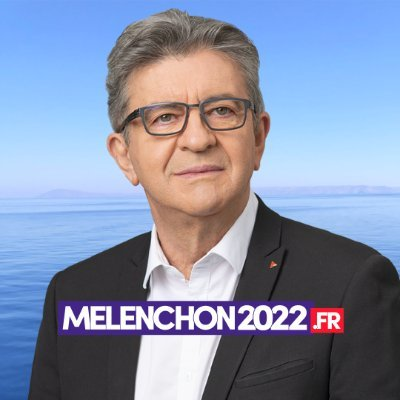

In [124]:
user_image(user="JLMelenchon")

In [60]:
def user_name(user):
    """
    Returns user's name
    """
    name = df_ready_for_nlp[df_ready_for_nlp["user"]==user]["name"].unique()[0]
    return name

In [125]:
user_name(user="JLMelenchon")

'Jean-Luc Mélenchon'

In [62]:
def user_political_party(user):
    """
    Returns user's political party
    """
    parti_politique = df_ready_for_nlp[df_ready_for_nlp["user"]==user]["political_party"].unique()[0]
    return parti_politique

In [126]:
user_political_party(user="JLMelenchon")

'La France Insoumise'

In [64]:
def user_political_oritentation(user):
    """
    Return user's political orientation
    """
    orientation_politique = df_ready_for_nlp[df_ready_for_nlp["user"]==user]["political_orientation"].unique()[0]
    return orientation_politique

In [127]:
user_political_oritentation(user="JLMelenchon")

'extrême_gauche'

## Ses thèmes de prédilection

In [66]:
def user_score_per_theme_vs_global_and_orientation(user):
    """
    Returns a bar graph with the score per theme for a given candidate and the mean global score for every candidates and for his/her political orientation
    """
    # Generate user score per theme
    user_scores = list(lexicon_score_per_user_df[lexicon_score_per_user_df["user"]==user].drop(columns="political_orientation").iloc[0])[1:]
    
    # Generate user political orientation average score per theme
    user_political_orientation = list(lexicon_score_per_user_df[lexicon_score_per_user_df["user"]==user]["political_orientation"])[0]
    # Generate his/her name
    user_name = list(lexicon_score_per_user_df[lexicon_score_per_user_df["user"]==user]["name"])[0]
    # Generate a df with the avg score per political orientation
    avg_score_per_political_orientation = lexicon_score_per_user_df.groupby(['political_orientation']).mean()
    # Store the right political orientation results in a variable
    political_orientation_scores = list(avg_score_per_political_orientation
                                  [avg_score_per_political_orientation.index==user_political_orientation]
                                  .iloc[0])
    
    # Generate national score per theme
    national_scores = list(avg_score_per_political_orientation.mean())
    
    # Define themes
    themes = avg_score_per_political_orientation.columns
    
    fig = go.Figure(data=[
                    go.Bar(name=f'{user_name} score', x=themes, y=user_scores),
                    go.Bar(name=f'{user_political_orientation} score', x=themes, y=political_orientation_scores),
                    go.Bar(name='National score', x=themes, y=national_scores)
                    ])
    
    # Change the bar mode
    fig.update_layout(barmode='group')
    
    return fig.show()

In [128]:
user_score_per_theme_vs_global_and_orientation(user="JLMelenchon")

## Les tweets les plus appréciés de sa communauté

In [94]:
def top_3_tweets_per_user(user):
    """
    Returns the top 3 tweets for a given user based on the total number of retweets
    """
    # Use global_df to display original tweets (before text cleaning). Sort this DataFrame per retweet_count
    df = global_df.sort_values(by="retweet_count", ascending=False)
    # Retrieve retweets
    df = df.loc[df["text"].isin([text for text in df["text"] if text[:2]!= "RT"])]
    # Only keep user's tweets
    df = df["url"][df["user"]==user]
    
    # Store the top 3 tweets in 3 variables
    first_tweet = df.iloc[0]
    second_tweet = df.iloc[1]
    third_tweet = df.iloc[2]
    
    # Store the "backslash n" in a  variable to use it in a "f string"
    new_line = "\n"
    # Define the full text to display
    text = f"Premier tweet le plus retweeter:{new_line}{first_tweet}{new_line}{new_line}Second tweet le plus retweeter:{new_line}{second_tweet}{new_line}{new_line}Troisième tweet le plus retweeter:{new_line}{third_tweet}"
    
    return print(text)

In [95]:
top_3_tweets_per_user(user="JLMelenchon")

Premier tweet le plus retweeter:
https://twitter.com/JLMelenchon/status/1461008990427561992

Second tweet le plus retweeter:
https://twitter.com/JLMelenchon/status/1460538657090248709

Troisième tweet le plus retweeter:
https://twitter.com/JLMelenchon/status/1462517975429390348


In [140]:
global_df[["political_orientation","name"]].drop_duplicates()["political_orientation"].value_counts()

divers            11
droite            10
gauche             6
extrême_gauche     6
extrême_droite     6
ecologie           3
Name: political_orientation, dtype: int64

## Les sujets qui l'animent

In [133]:
def test_top_five_words_per_theme_per_user(name):
    """
    Returns Top 5 words per theme for a given user based on the number of time he/she use it
    """
    # Store all the user words in a list
    user_words = []
    # Extract all his/her tweets
    user_tweets = list(df_ready_for_nlp[df_ready_for_nlp["name"]==name]["text"])
    # Go for each tweet
    for tweet in user_tweets:
        # Tokenize each tweet to analyze its content
        tokenized_tweet = word_tokenize(tweet)
        # Go for each word
        for word in tokenized_tweet:
            # Append it to the list
            user_words.append(word)
    
    # Create a dictionary that will store the top words for every theme
    top_words_per_theme_dict = {}
    # Go in Lexicon_themes and dissociate theme and lexicon
    for theme, lexicon in lexicon_themes.items():
        # Create a dictionary that will store the top words only for this theme 
        top_words_for_this_theme_dict ={}
        # Iterate over each word stored in this lexicon
        for word in lexicon:
            # Count how many times it appears in user_words
            score = user_words.count(word)
            # Store how many times the given user used this word, in the dictionary created for this only theme
            top_words_for_this_theme_dict[word] = score
        # Now that we iterate over every words stored in this theme, sort it per word's score
        sorted_top_words_for_this_theme_dict = sorted(top_words_for_this_theme_dict.items(), key = lambda kv: kv[1], reverse=True)
        # Only keep the first five
        top_words_per_theme_dict[theme] = sorted_top_words_for_this_theme_dict[:5]
    
    empty_space = " "
    for theme, top_words in top_words_per_theme_dict.items():
        for word in top_words:
            if word[-1] == 0:
                top_words[top_words.index(word)] = empty_space
    
    # Convert the dictionary with the top 5 words per theme into a DataFrame
    top_words_per_theme = pd.DataFrame(top_words_per_theme_dict)
    # Raise the index by 1 to start at 1
    top_words_per_theme.index += 1 
    
    # Transpose the DataFrame to fix the themes as index
    return top_words_per_theme.T

    return top_words_per_theme_dict

In [134]:
test_top_five_words_per_theme_per_user(name="Alex Langlois")

,1,2,3,4,5
Politique,"(democratie, 16)","(programme, 15)","(presidentielle, 15)","(responsabilite, 9)","(liberte, 9)"
Actualité,"(benalla, 32)","(democratie, 16)","(candidats, 12)","(demain, 11)","(candidat, 11)"
Candidats,"(alexlanglois, 23)","(macron, 19)","(emmanuelmacron, 12)","(macronie, 9)","(dupontaignan, 7)"
Travail,"(affaire, 22)","(temps, 5)","(syndicat, 3)","(oeuvre, 3)","(fonction, 3)"
Santé,"(passsanitaire, 6)","(sanitaire, 5)","(masque, 5)","(patient, 5)","(nature, 5)"
Economie,"(crise, 5)","(service, 2)","(cote, 2)","(ressource, 1)","(production, 1)"
Sécurité,"(responsable, 11)","(police, 7)","(policier, 6)","(loi, 6)","(surete, 3)"
Extrême,"(terrible, 1)","(sommet, 1)","(maximum, 1)","(heroique, 1)","(contraire, 1)"
Ecologie,"(nature, 5)","(cours, 2)","(environnement, 1)","(ecosysteme, 1)","(ecologique, 1)"
Pouvoir_achat,"(retraite, 1)","(prix, 1)","(pauvrete, 1)",,


## How he/she use tweeter

In [ ]:
def user_number_of_tweets(name):
    """
    Returns the number of tweets in archive for a given candidate
    """
    
    return nb

In [149]:
# user_number_of_tweets = len(global_df[global_df["name"]=="Alex Langlois"])
# user_number_of_tweets

200

In [166]:
def user_tweeter_use(name):
    """
    Returns number of tweets, time since his/her oldest tweet in archive, mean_tweet_per_day, number_of_author_tweets, percentage_author_tweet for a given candidate
    and all_candidates_percentage_author_tweet and all_candidates_percentage_author_tweet for all candidates
    """
    # Number of tweets archive
    nb = len(global_df[global_df["name"]==name])
    
    # Oldest tweet date
    user_oldest_tweet = datetime.strptime(min(global_df[global_df["name"]==name]["created_date"]), "%Y-%m-%d")
    today = datetime.strptime(date.today().strftime("%Y-%m-%d"), "%Y-%m-%d")
    # Time since his/her oldest tweet in archive
    time = abs((today - user_oldest_tweet).days)
    # Mean tweet per day
    mean_tweet_per_day = round(nb/time,0)
    
    # DataFrame without Retweets
    df_without_retweets = global_df.loc[global_df["text"].isin([text for text in global_df["text"] if text[:2]!= "RT"])]
    # Number of tweets which the candidate is the author
    number_of_author_tweets = len(df_without_retweets[df_without_retweets["name"]==name])
    # Percentage of his/her "author tweets"
    percentage_author_tweet = round(user_number_of_author_tweets/user_number_of_tweets,2)
    # All candidates number of author tweets
    all_candidates_number_of_author_tweets = len(df_without_retweets)
    # All candidates number of tweets
    all_candidates_total_number_of_tweets = len(global_df)
    # Global percentage of "author tweet"
    all_candidates_percentage_author_tweet = round(all_candidates_number_of_author_tweets/all_candidates_total_number_of_tweets,2)
    
    return nb, time, mean_tweet_per_day, number_of_author_tweets, percentage_author_tweet, all_candidates_percentage_author_tweet

In [167]:
nb, time, mean_tweet_per_day, number_of_author_tweets, percentage_author_tweet, all_candidates_percentage_author_tweet =user_tweeter_use(name="Alex Langlois")

In [169]:
nb, time, mean_tweet_per_day, number_of_author_tweets, percentage_author_tweet, all_candidates_percentage_author_tweet

(200, 133, 2.0, 164, 0.82, 0.75)